In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("alyce_facts_final.csv")
df.head()

,order_id,client_id,service_id,gift_id,gift_cost,total_gifts,total_amount,fee,variable_cost,total_revenue,month,year,date
0,11110,419,1,16,1289.54,13,16764,3352.8,4326,20116.8,3,2018,3-2018
1,11111,503,3,21,235.66,50,11783,2356.6,5976,14139.6,10,2019,10-2019
2,11112,395,2,23,211.97,71,15050,3010.0,4836,18060.0,3,2019,3-2019
3,11113,292,1,22,445.24,38,16919,3383.8,6144,20302.8,6,2019,6-2019
4,11114,408,1,14,1247.91,11,13727,2745.4,5632,16472.4,4,2018,4-2018


In [2]:
import seaborn as sns
sns.set_palette("husl")
sns.set(rc={'image.cmap': 'coolwarm'})
%matplotlib inline

In [3]:
import datetime as dt
df['Date'] = pd.to_datetime(df['date']).dt.date

In [4]:
df = df[pd.notnull(df['client_id'])]
df = df[(df['total_gifts']>0)]


In [5]:
df['Sales'] = df['total_revenue']
cols_of_interest = ['client_id', 'Date', 'Sales']
df = df[cols_of_interest]

In [7]:
print(df.head())
print(df['client_id'].nunique())

   client_id        Date    Sales
0        419  2018-03-01  20116.8
1        503  2019-10-01  14139.6
2        395  2019-03-01  18060.0
3        292  2019-06-01  20302.8
4        408  2018-04-01  16472.4
421


In [11]:
!pip install lifetimes.estimation

  Could not find a version that satisfies the requirement lifetimes.estimation (from versions: )
No matching distribution found for lifetimes.estimation


In [13]:
from lifetimes.plotting import *
from lifetimes.utils import *

data = summary_data_from_transaction_data(df, 'client_id', 'Date', monetary_value_col='Sales', observation_period_end='2019-12-1')
data.head()

,frequency,recency,T,monetary_value
client_id,,,,
111,9.0,668.0,668.0,18147.866667
112,3.0,515.0,668.0,28781.600000
113,6.0,549.0,579.0,21119.800000
114,5.0,549.0,579.0,24541.440000
115,6.0,518.0,640.0,20083.600000


count    421.000000
mean       6.845606
std        2.338581
min        1.000000
25%        5.000000
50%        7.000000
75%        8.000000
max       13.000000
Name: frequency, dtype: float64
0.0


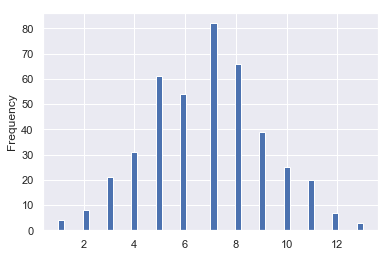

In [14]:
data['frequency'].plot(kind='hist', bins=50)
print(data['frequency'].describe())
print(sum(data['frequency'] == 0)/float(len(data)))

In [47]:

from lifetimes import BetaGeoFitter

# similar API to scikit-learn and lifelines.
bgf = BetaGeoFitter(penalizer_coef=0.1)
bgf.fit(data['frequency'], data['recency'], data['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 421 subjects, a: 0.00, alpha: 131.06, b: 0.00, r: 1.42>


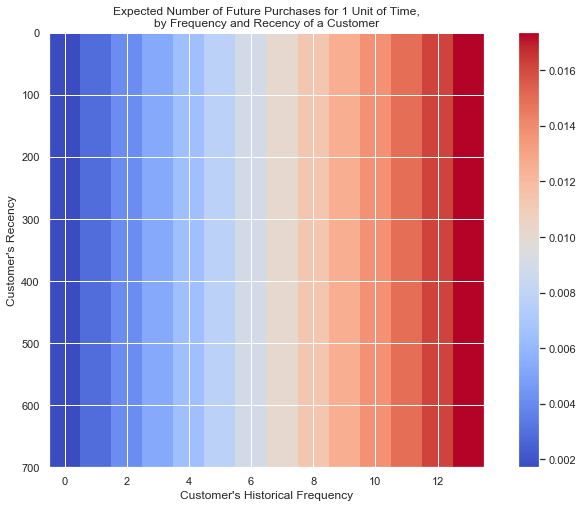

In [48]:
from lifetimes.plotting import plot_frequency_recency_matrix
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf)

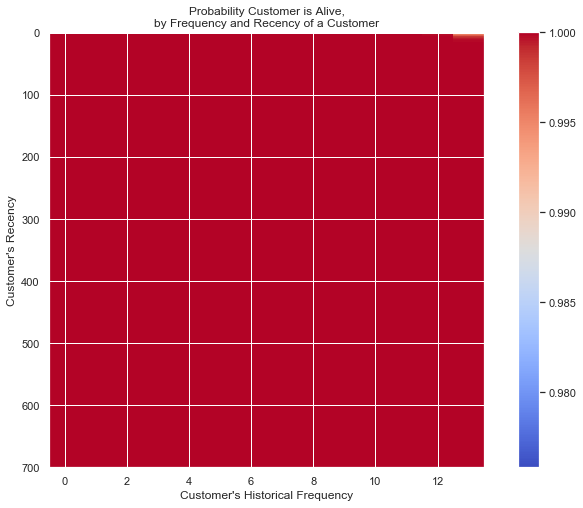

In [19]:
from lifetimes.plotting import plot_probability_alive_matrix
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)


In [20]:

t = 1
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
client_id,,,,,
359,13.0,699.0,699.0,25977.784615,0.018299
238,12.0,640.0,640.0,22139.500000,0.018418
170,12.0,610.0,640.0,22454.500000,0.018418
531,12.0,640.0,640.0,22095.200000,0.018418
252,13.0,638.0,668.0,24641.538462,0.019112


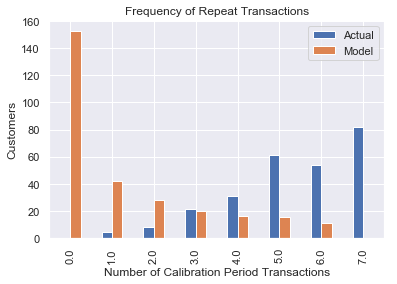

In [21]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

In [23]:
from lifetimes.utils import calibration_and_holdout_data

summary_cal_holdout = calibration_and_holdout_data(df, 'client_id', 'Date',
                                        calibration_period_end='2019-06-01',
                                        observation_period_end='2019-12-01' )   
print(summary_cal_holdout.head())

           frequency_cal  recency_cal  T_cal  frequency_holdout  \
client_id                                                         
111                  6.0        393.0  485.0                3.0   
112                  2.0        273.0  485.0                1.0   
113                  4.0        304.0  396.0                2.0   
114                  4.0        245.0  396.0                1.0   
115                  5.0        426.0  457.0                1.0   

           duration_holdout  
client_id                    
111                     183  
112                     183  
113                     183  
114                     183  
115                     183  


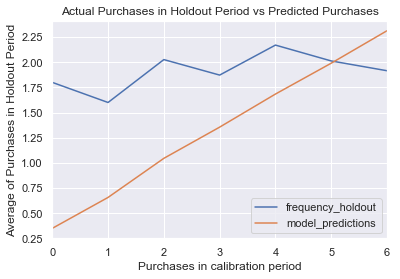

In [24]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

In [29]:
t = 10 #predict purchases in 10 periods
individual = data.loc[359]
# The below function is an alias to `bfg.conditional_expected_number_of_purchases_up_to_time`
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

0.18319597532895351

In [30]:
data.loc[359]

frequency                 13.000000
recency                  699.000000
T                        699.000000
monetary_value         25977.784615
predicted_purchases        0.018299
Name: 359, dtype: float64

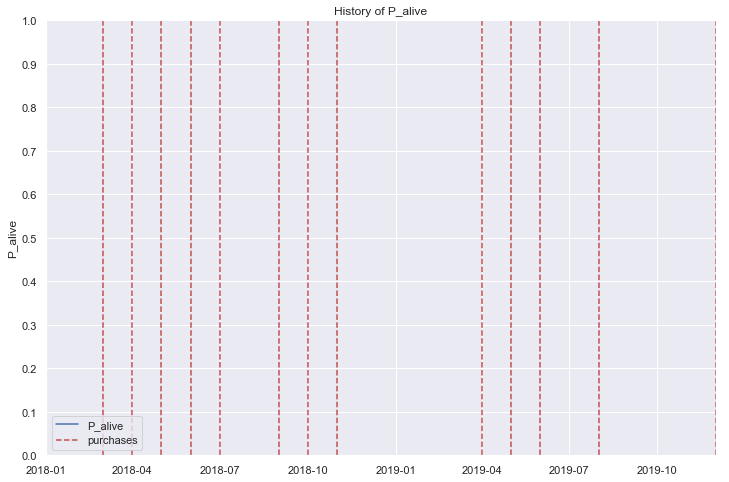

In [36]:
from lifetimes.plotting import plot_history_alive
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,8))
id = 359
days_since_birth = 365
sp_trans = df.loc[df['client_id'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'Date')

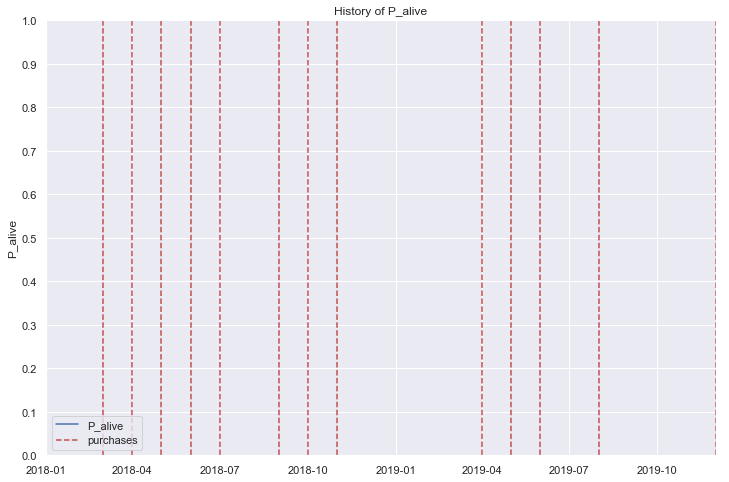

In [56]:
fig = plt.figure(figsize=(12,8))
id = 359
days_since_birth = 365
sp_trans = df.loc[df['client_id'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'Date')

In [38]:
returning_customers_summary = data[data['frequency']>0]

print(returning_customers_summary.head())
print(len(returning_customers_summary))

           frequency  recency      T  monetary_value  predicted_purchases
client_id                                                                
111              9.0    668.0  668.0    18147.866667             0.013374
112              3.0    515.0  668.0    28781.600000             0.004767
113              6.0    549.0  579.0    21119.800000             0.010398
114              5.0    549.0  579.0    24541.440000             0.008754
115              6.0    518.0  640.0    20083.600000             0.009450
421


In [39]:
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.060359
frequency,0.060359,1.000000


In [57]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0.1)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 421 subjects, p: 0.73, q: 0.10, v: 0.70>


In [42]:
print(ggf.conditional_expected_average_profit(
        data['frequency'],
        data['monetary_value']
    ).head(10))

client_id
111     70112.226340
112    -23524.426639
113   -189009.650578
114    -73458.243159
115   -179736.284570
116    -33636.342786
117     47621.265003
118    -15631.849668
119    -64923.945204
120     66528.385647
dtype: float64


In [43]:
bgf.fit(data['frequency'], data['recency'], data['T'])

print(ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    data['frequency'],
    data['recency'],
    data['T'],
    data['monetary_value'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
).head(10))

client_id
111    316619.357099
112    -37867.432417
113   -663624.461708
114   -217128.380572
115   -573532.972802
116    -67437.956814
117    250064.375645
118    -38542.879208
119   -160274.851670
120    332659.098829
Name: clv, dtype: float64
